In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import PIL.Image
import PIL.ImageOps
import numpy as np

In [2]:
CSVPATH = "./csv/"
TXTPATH = "./txt/"
IMAGESPATH = "./images/"
CORRIMAGESPATH = "./images_corrected/"
files = os.listdir(CSVPATH)

categ = {"pant":0,"skirt":1,"dress":2,"shoes":3,"hat":4,"coat":5,"shirt":6,"pull":7}

In [3]:
def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274
    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]
        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)
    return orientation, img


def load_image_file(file, mode='RGB'):
    # Load the image with PIL
    img = PIL.Image.open(file)
    orientation, img = exif_transpose(img)
    img = img.convert(mode)
    npimg = np.array(img)
    return orientation, npimg

In [57]:
def annotation_csv_to_txt():
    """
    transform csv files obtained with vgg annotator
    to txt files to be consumed by yolo for training.
    create a txt file per picture with same name
    format in txt file <class> <xcenter> <ycenter> <width> <height>
    values in txt files are float realtive to image width and height.
    """
    for file in files:
        mypd = pd.read_csv(os.path.join(CSVPATH,file))
        for f in mypd.filename.unique():
            root,ext = os.path.splitext(f)
            orientation, img = load_image_file(os.path.join(IMAGESPATH,f))
            im_h, im_w, im_lev = img.shape
            
            # save image with correct orientation in images_corrected folder
            img = Image.fromarray(img, 'RGB')
            img.save(os.path.join(CORRIMAGESPATH,f))
            
            output = []
            for idx,line in mypd[mypd['filename']==f].iterrows():
                mydict = eval(line.region_shape_attributes)
                x=mydict['x']
                y=mydict['y']
                w=mydict['width']
                h=mydict['height']
                # need to modify boxes coordinates to reflect orientation.
#                 print("orientation:",orientation)
#                 print(type(orientation))
                cx = x
                cy = y
                cw = w
                ch = h
                cim_w = im_w
                cim_h = im_h
                # Handle EXIF Orientation
                if orientation == 1:
                    # Normal image - nothing to do!
                    pass
                elif orientation == 2:
                    # Mirrored left to right
                    cx = -x
                elif orientation == 3:
                    # Rotated 180 degrees
                    cx = -x
                    cy = -y
                elif orientation == 4:
                    # Mirrored top to bottom
                    cy = -y
                elif orientation == 5:
                    # Mirrored along top-left diagonal
                    pass
                elif orientation == 6:
                    # Rotated 90 degrees
                    print(x,y,w,h)
                    cx = y - h
                    cy = x
                    cw = h
                    ch = w
                    cim_h = cim_w
                    cim_w = cim_h
                    print(cx,cy,cw,ch)
                elif orientation == 7:
                    # Mirrored along top-right diagonal
                    pass
                elif orientation == 8:
                    # Rotated 270 degrees
                    pass
                    
                mylabeldict = eval(line.region_attributes)
                cat = categ[mylabeldict['clothe']]
                
                xcenter = (cx + cw / 2) / cim_w
                ycenter = (cy + ch / 2) / cim_h
                dwidth = cw / cim_w
                dheight = ch / cim_h
                
                output.append([cat,xcenter,ycenter,dwidth,dheight])
                
            outputf = pd.DataFrame(output)
            outputf.to_csv(os.path.join(TXTPATH,root+".txt"),index=False,header=False,sep=" ")

In [58]:
annotation_csv_to_txt()

1482 1261 1093 770
491 389 770 1093
2497 1322 925 590
732 1572 590 925
3357 1363 291 594
769 3066 594 291


ParserError: Error tokenizing data. C error: Expected 1 fields in line 3, saw 5


In [54]:
def checkboxes(filename):
    mypd = pd.read_csv(os.path.join(TXTPATH,filename+".txt"),sep=" ",header=None)
    image = cv2.imread(os.path.join(CORRIMAGESPATH,filename+".jpg")) 
    im_h, im_w , lev = image.shape
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for idx, line in mypd.iterrows():
        xcenter = line[1] * im_w
        ycenter= line[2] * im_h
        width = line[3] * im_w
        height = line[4] * im_h
        x = (xcenter-width/2)
        y = (ycenter-height/2)
        w = width 
        h = height
    #     print(x,y,w,h)
        rect = patches.Rectangle((x,y),w,h,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    # ax.figure(figsize=(10,10))
    # rect = patches.Rectangle((x,y),w,h,edgecolor='r',facecolor='none')
    plt.show()

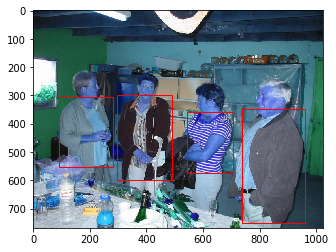

In [55]:
filename = '127-2737_IMG'
checkboxes(filename)

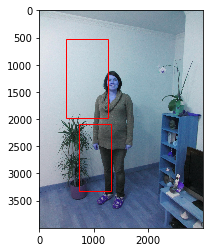

In [59]:
filename = '150121'
checkboxes(filename)

In [10]:
f = '127-2737_IMG.JPG'
x,y = load_image_file(os.path.join(IMAGESPATH,f))
plt.imshow(img)

NameError: name 'img' is not defined

In [35]:
x

1